In [109]:
"""
Classical Machine Learning for Kidney CT Classification
Comparison: SVM (Linear, RBF, Poly), KNN (Manual), Random Forest, Logistic Regression
Using 5-Fold Cross-Validation for model evaluation
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import pickle
import time
import warnings

# Suppress sklearn convergence warnings (we handle them with increased max_iter)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='.*Liblinear failed to converge.*')
warnings.filterwarnings('ignore', message='.*lbfgs failed to converge.*')

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

print("Classical ML Models for Kidney CT Classification")
print("Validation Method: 5-Fold Cross-Validation")
print("Optimization: PCA for dimensionality reduction (speeds up SVM)")

Classical ML Models for Kidney CT Classification
Validation Method: 5-Fold Cross-Validation
Optimization: PCA for dimensionality reduction (speeds up SVM)


In [110]:
# Load dataset configuration
CONFIG_PATH = '../data/dataset_config.json'
assert os.path.exists(CONFIG_PATH), "Run 01_data_analysis_processing.ipynb first!"

with open(CONFIG_PATH) as f:
    config = json.load(f)

DATA_PATH = config['data_path']
IMAGE_SIZE = 224  #(224x224x3 = 150,528 features)
N_FOLDS = 5  # 5-Fold Cross-Validation
N_PCA_COMPONENTS = 100  # Reduce to 100 dimensions (speeds up SVM significantly)

OUTPUT_DIR = '../outputs/ml'
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)

print(f"Data: {DATA_PATH}")
print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE} (raw: {IMAGE_SIZE*IMAGE_SIZE*3} features)")
print(f"PCA Components: {N_PCA_COMPONENTS} (dimensionality reduction)")
print(f"Validation: {N_FOLDS}-Fold Cross-Validation on training data")

Data: c:\Users\ELJOE\Desktop\masters\machine\project\data\processed
Image Size: 224x224 (raw: 150528 features)
PCA Components: 100 (dimensionality reduction)
Validation: 5-Fold Cross-Validation on training data


In [111]:
def load_images_as_features(data_path, image_size):
    """Load images and flatten to feature vectors."""
    X, y = [], []
    class_names = sorted(os.listdir(data_path))
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for filename in tqdm(files, desc=class_name, leave=False):
            img_path = os.path.join(class_path, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((image_size, image_size))
            img_array = np.array(img).flatten() / 255.0  # Normalize to [0,1]
            X.append(img_array)
            y.append(class_idx)
    
    return np.array(X), np.array(y), class_names

print("Loading training data...")
X_train_full, y_train_full, class_names = load_images_as_features(os.path.join(DATA_PATH, 'train'), IMAGE_SIZE)
print(f"Loaded {len(X_train_full)} training samples")

print("Loading test data...")
X_test, y_test, _ = load_images_as_features(os.path.join(DATA_PATH, 'test'), IMAGE_SIZE)
print(f"Loaded {len(X_test)} test samples")

print(f"\nClasses: {class_names}")
print(f"Train shape: {X_train_full.shape}")
print(f"Test shape: {X_test.shape}")

Loading training data...


Loaded 9411 training samples
Loading test data...


Loaded 4034 test samples

Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Train shape: (9411, 150528)
Test shape: (4034, 150528)


In [112]:
# Use full training data
X_train_sub = X_train_full
y_train_sub = y_train_full

print(f"Training data: {X_train_sub.shape[0]} samples (full dataset)")

# Step 1: Standardize features
print("\nStep 1: Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sub)
X_test_scaled = scaler.transform(X_test)

# Step 2: Apply PCA for dimensionality reduction (speeds up SVM training)
print(f"Step 2: Applying PCA ({X_train_scaled.shape[1]} -> {N_PCA_COMPONENTS} dimensions)...")
pca = PCA(n_components=N_PCA_COMPONENTS, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nDimensionality reduction complete:")
print(f"  Before PCA: {X_train_scaled.shape[1]} features")
print(f"  After PCA:  {X_train_pca.shape[1]} features")
print(f"  Variance retained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Setup 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
print(f"\n5-Fold CV Setup:")
print(f"  Training samples: {len(X_train_pca)}")
print(f"  Each fold validation: ~{len(X_train_pca)//N_FOLDS} samples")
print(f"  Each fold training: ~{len(X_train_pca) - len(X_train_pca)//N_FOLDS} samples")

Training data: 9411 samples (full dataset)

Step 1: Standardizing features...
Step 2: Applying PCA (150528 -> 100 dimensions)...

Dimensionality reduction complete:
  Before PCA: 150528 features
  After PCA:  100 features
  Variance retained: 73.2%

5-Fold CV Setup:
  Training samples: 9411
  Each fold validation: ~1882 samples
  Each fold training: ~7529 samples


In [113]:
# Define SVM models with different kernels
# LinearSVC is faster than SVC(kernel='linear') for large datasets
svm_models = {
    'SVM (Linear)': LinearSVC(C=1.0, random_state=SEED, max_iter=5000, dual='auto'),
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=SEED, cache_size=500),
    'SVM (Poly)': SVC(kernel='poly', C=1.0, degree=3, gamma='scale', random_state=SEED, cache_size=500),
}

# Other ML models
other_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=SEED, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=2000, C=1.0, random_state=SEED, n_jobs=-1)
}

print("Models to train:")
print("\nSVM Models:")
for name in svm_models:
    print(f"  - {name}")
print("\nOther Models:")
for name in other_models:
    print(f"  - {name}")
print("  - KNN (Manual Implementation)")

Models to train:

SVM Models:
  - SVM (Linear)
  - SVM (RBF)
  - SVM (Poly)

Other Models:
  - Random Forest
  - Logistic Regression
  - KNN (Manual Implementation)


In [114]:
# ============================================================
# Manual KNN Implementation (from lab code)
# ============================================================

def compute_distances_two_loops(X, X_train):
    """
    Compute the distance between each test point in X and each training point
    in X_train using a nested loop over both the training data and the test data.
    """
    num_test = X.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
            dists[i][j] = np.sqrt(sum((X[i] - X_train[j])**2))
    return dists

def compute_distances_one_loop(X, X_train):
    """
    Compute the distance between each test point in X and each training point
    in X_train using a single loop over the test data.
    """
    num_test = X.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        dists[i, :] = np.sqrt(np.sum((X[i] - X_train)**2, axis=1))
    return dists

def compute_distances_no_loops(X, X_train):
    """
    Compute the distance between each test point in X and each training point
    in X_train using no explicit loops (vectorized).
    Uses numerical stability fix to avoid negative values before sqrt.
    """
    m = X.shape[0]
    n = X_train.shape[0]
    x2 = np.sum(X**2, axis=1).reshape((m, 1))
    y2 = np.sum(X_train**2, axis=1).reshape((1, n))
    xy = X.dot(X_train.T)
    # Clip to avoid negative values due to numerical precision (fixes RuntimeWarning)
    dists = np.sqrt(np.maximum(x2 + y2 - 2*xy, 0))
    return dists

def predict_labels(dists, y_train, k):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test, dtype=int)
    
    for i in range(num_test):
        # Sort by index to find k nearest neighbors
        index_sort = np.argsort(dists[i])[:k]
        # Get labels of k nearest neighbors
        closest_y = y_train[index_sort]
        # Find most common label (majority vote)
        occurances = np.bincount(closest_y)
        y_pred[i] = np.argmax(occurances)
    
    return y_pred

class ManualKNN:
    """Manual KNN implementation without using sklearn."""
    def __init__(self, k=5, distance_method='no_loops'):
        self.k = k
        self.distance_method = distance_method
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        # Choose distance computation method
        if self.distance_method == 'two_loops':
            dists = compute_distances_two_loops(X, self.X_train)
        elif self.distance_method == 'one_loop':
            dists = compute_distances_one_loop(X, self.X_train)
        else:  # no_loops (vectorized - fastest)
            dists = compute_distances_no_loops(X, self.X_train)
        
        return predict_labels(dists, self.y_train, self.k)

print("Manual KNN implementation loaded!")
print("Distance methods available: two_loops, one_loop, no_loops (vectorized)")

Manual KNN implementation loaded!
Distance methods available: two_loops, one_loop, no_loops (vectorized)


In [115]:
def get_model_folder_name(name):
    """Convert model name to folder-safe name."""
    return name.lower().replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').replace('-', '_')

def train_and_evaluate(name, model, X_train, y_train, X_test, y_test, skf, use_manual_cv=False):
    """Train a model with 5-Fold CV and evaluate on test set."""
    print(f"Training: {name}")
    print("-" * 40)
    
    start_time = time.time()
    
    if use_manual_cv:
        # Manual CV for custom KNN
        cv_scores = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
            model_fold = ManualKNN(k=model.k, distance_method=model.distance_method)
            model_fold.fit(X_train[train_idx], y_train[train_idx])
            fold_acc = accuracy_score(y_train[val_idx], model_fold.predict(X_train[val_idx]))
            cv_scores.append(fold_acc)
        cv_scores = np.array(cv_scores)
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    
    cv_time = time.time() - start_time
    
    # Train on full data
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)
    
    print(f"Time: {cv_time:.1f}s | Train: {train_acc:.4f} | CV: {cv_scores.mean():.4f} (+/-{cv_scores.std()*2:.4f}) | Test: {test_acc:.4f}")
    
    return {
        'model': model, 'train_acc': train_acc,
        'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std(),
        'cv_scores': cv_scores, 'test_acc': test_acc,
        'test_preds': test_preds, 'train_time': cv_time
    }

results = {}
print("Training functions defined.")

Training functions defined.


## Train SVM Models

In [116]:
for name, model in svm_models.items():
    results[name] = train_and_evaluate(name, model, X_train_pca, y_train_sub, X_test_pca, y_test, skf)
    print()

Training: SVM (Linear)
----------------------------------------
Time: 70.3s | Train: 0.9701 | CV: 0.9672 (+/-0.0057) | Test: 0.9710

Training: SVM (RBF)
----------------------------------------
Time: 2.1s | Train: 0.9961 | CV: 0.9936 (+/-0.0028) | Test: 0.9948

Training: SVM (Poly)
----------------------------------------
Time: 1.3s | Train: 0.9913 | CV: 0.9858 (+/-0.0064) | Test: 0.9903



## Train Manual KNN

In [117]:
knn_manual = ManualKNN(k=5, distance_method='no_loops')
results['KNN (Manual, k=5)'] = train_and_evaluate(
    'KNN (Manual, k=5)', knn_manual, X_train_pca, y_train_sub, X_test_pca, y_test, skf, use_manual_cv=True
)

Training: KNN (Manual, k=5)
----------------------------------------
Time: 1.1s | Train: 0.9997 | CV: 0.9986 (+/-0.0013) | Test: 0.9990


## Train Random Forest & Logistic Regression

In [118]:
for name, model in other_models.items():
    results[name] = train_and_evaluate(name, model, X_train_pca, y_train_sub, X_test_pca, y_test, skf)
    print()

print(f"All {len(results)} models trained successfully!")

Training: Random Forest
----------------------------------------
Time: 1.2s | Train: 1.0000 | CV: 0.9992 (+/-0.0016) | Test: 0.9995

Training: Logistic Regression
----------------------------------------
Time: 6.7s | Train: 0.9947 | CV: 0.9853 (+/-0.0076) | Test: 0.9896

All 6 models trained successfully!


## Save Model Results

In [119]:
# Save individual model results to separate folders
for name, res in results.items():
    folder_name = get_model_folder_name(name)
    model_dir = os.path.join(OUTPUT_DIR, folder_name)
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model
    with open(os.path.join(model_dir, 'model.pkl'), 'wb') as f:
        pickle.dump({'model': res['model'], 'scaler': scaler, 'pca': pca,
                     'model_name': name, 'class_names': class_names,
                     'image_size': IMAGE_SIZE, 'n_pca_components': N_PCA_COMPONENTS}, f)
    
    # Save results JSON
    with open(os.path.join(model_dir, 'results.json'), 'w') as f:
        json.dump({'model_name': name, 'train_accuracy': float(res['train_acc']),
                   'cv_mean': float(res['cv_mean']), 'cv_std': float(res['cv_std']),
                   'test_accuracy': float(res['test_acc']), 'train_time': float(res['train_time'])}, f, indent=2)
    
    # Save confusion matrix
    cm = confusion_matrix(y_test, res['test_preds'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(f'{name} - Confusion Matrix (Acc: {res["test_acc"]:.4f})')
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'confusion_matrix.png'), dpi=150)
    plt.close()
    
    print(f"Saved: {folder_name}/")

Saved: svm_linear/
Saved: svm_rbf/
Saved: svm_poly/
Saved: knn_manual_k=5/
Saved: random_forest/
Saved: logistic_regression/


## Results Comparison

In [120]:
# Results comparison table with 5-Fold CV
print("\n" + "="*90)
print("MODEL COMPARISON (5-Fold Cross-Validation)")
print("="*90)
print(f"{'Model':<25} {'Train Acc':>10} {'CV Mean':>10} {'CV Std':>10} {'Test Acc':>10} {'Time (s)':>10}")
print("-"*90)

for name, res in sorted(results.items(), key=lambda x: x[1]['test_acc'], reverse=True):
    print(f"{name:<25} {res['train_acc']:>10.4f} {res['cv_mean']:>10.4f} {res['cv_std']:>10.4f} {res['test_acc']:>10.4f} {res['train_time']:>10.1f}")

# Best model by CV score
best_cv_name = max(results, key=lambda x: results[x]['cv_mean'])
# Best model by test score
best_test_name = max(results, key=lambda x: results[x]['test_acc'])

print(f"\nBest ML Model (by 5-Fold CV): {best_cv_name} (CV: {results[best_cv_name]['cv_mean']:.4f})")
print(f"Best ML Model (by Test Acc): {best_test_name} (Test: {results[best_test_name]['test_acc']:.4f})")


MODEL COMPARISON (5-Fold Cross-Validation)
Model                      Train Acc    CV Mean     CV Std   Test Acc   Time (s)
------------------------------------------------------------------------------------------
Random Forest                 1.0000     0.9992     0.0008     0.9995        1.2
KNN (Manual, k=5)             0.9997     0.9986     0.0006     0.9990        1.1
SVM (RBF)                     0.9961     0.9936     0.0014     0.9948        2.1
SVM (Poly)                    0.9913     0.9858     0.0032     0.9903        1.3
Logistic Regression           0.9947     0.9853     0.0038     0.9896        6.7
SVM (Linear)                  0.9701     0.9672     0.0029     0.9710       70.3

Best ML Model (by 5-Fold CV): Random Forest (CV: 0.9992)
Best ML Model (by Test Acc): Random Forest (Test: 0.9995)


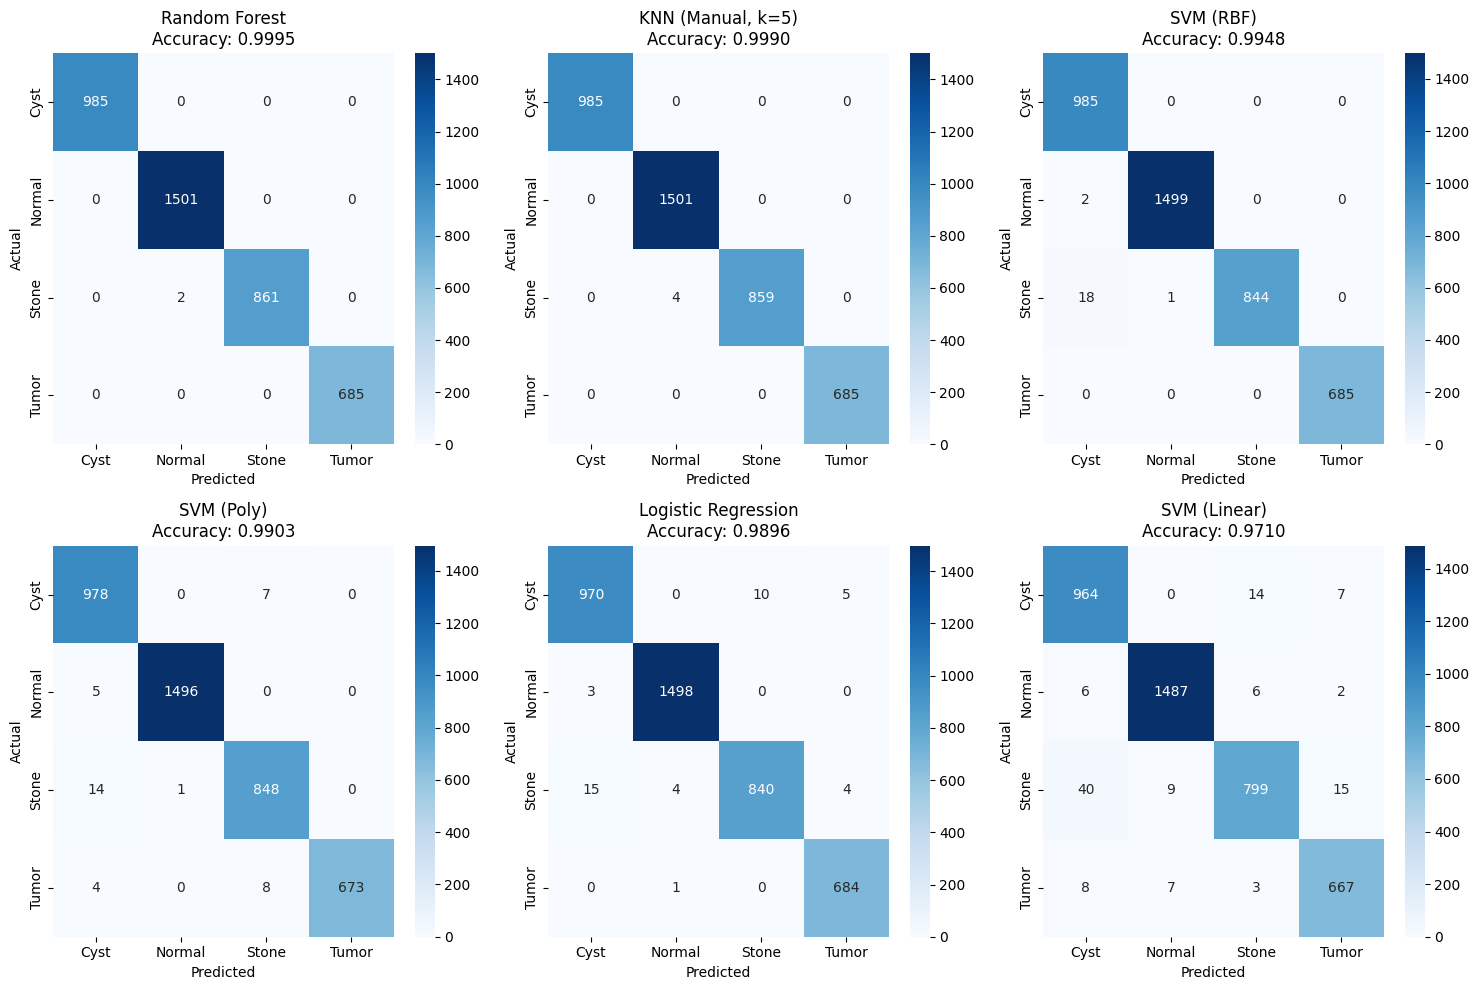

In [121]:
# Confusion matrices (showing top 6 models)
num_models = len(results)
cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
axes = axes.flatten()

for idx, (name, res) in enumerate(sorted(results.items(), key=lambda x: x[1]['test_acc'], reverse=True)):
    if idx >= len(axes):
        break
    cm = confusion_matrix(y_test, res['test_preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
    axes[idx].set_title(f"{name}\nAccuracy: {res['test_acc']:.4f}")
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide unused subplots
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), dpi=150)
plt.show()

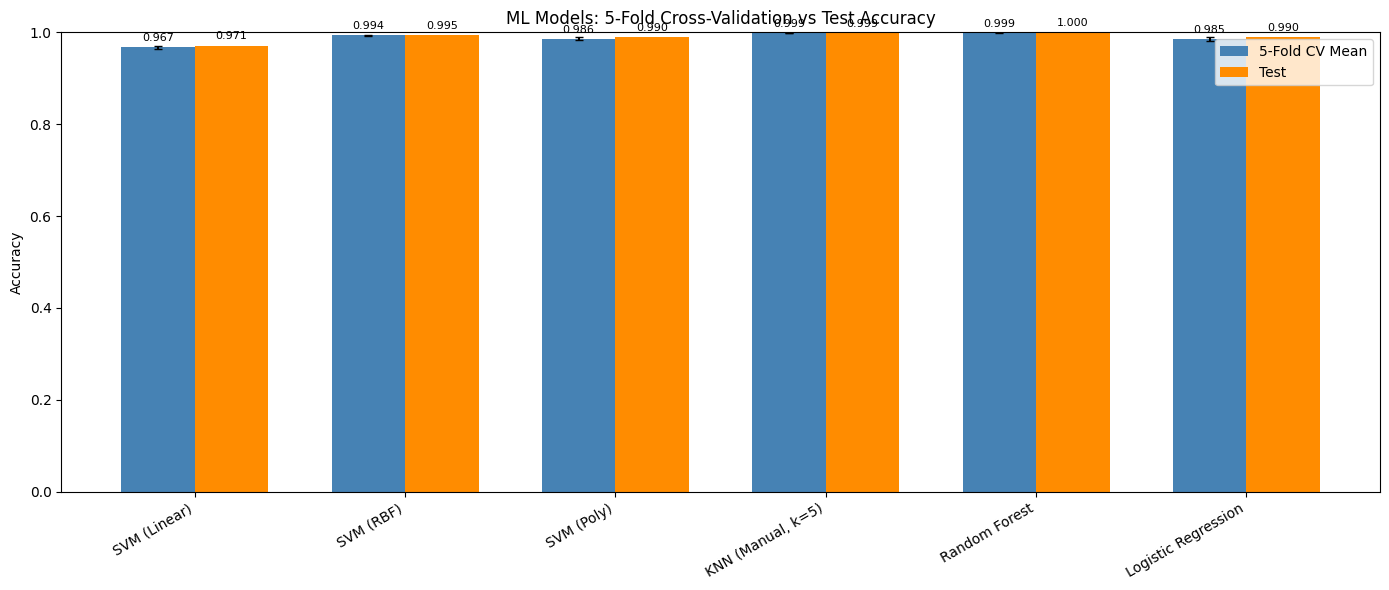

In [122]:
# Accuracy comparison bar chart (CV vs Test)
fig, ax = plt.subplots(figsize=(14, 6))

model_names = list(results.keys())
cv_accs = [results[n]['cv_mean'] for n in model_names]
cv_stds = [results[n]['cv_std'] for n in model_names]
test_accs = [results[n]['test_acc'] for n in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, cv_accs, width, label='5-Fold CV Mean', color='steelblue', yerr=cv_stds, capsize=3)
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', color='darkorange')

ax.set_ylabel('Accuracy')
ax.set_title('ML Models: 5-Fold Cross-Validation vs Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=30, ha='right')
ax.legend()
ax.set_ylim(0, 1)

# Add value labels
for bar, acc in zip(bars1, cv_accs):
    ax.annotate(f'{acc:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)
for bar, acc in zip(bars2, test_accs):
    ax.annotate(f'{acc:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_comparison.png'), dpi=150)
plt.show()

In [123]:
# Save best model (by test accuracy) - include scaler and PCA for inference
best_name = best_test_name
best_model = results[best_name]['model']
model_path = os.path.join(OUTPUT_DIR, 'best_model.pkl')

with open(model_path, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'pca': pca,
        'model_name': best_name,
        'class_names': class_names,
        'image_size': IMAGE_SIZE,
        'n_pca_components': N_PCA_COMPONENTS,
        'cv_accuracy': results[best_name]['cv_mean'],
        'cv_std': results[best_name]['cv_std'],
        'test_accuracy': results[best_name]['test_acc']
    }, f)

# Save combined ML results JSON
ml_combined_results = {
    'models': [
        {
            'model_name': name,
            'train_accuracy': float(res['train_acc']),
            'cv_mean': float(res['cv_mean']),
            'cv_std': float(res['cv_std']),
            'test_accuracy': float(res['test_acc']),
            'train_time': float(res['train_time'])
        }
        for name, res in results.items()
    ],
    'best_model': best_name,
    'best_accuracy': float(results[best_name]['test_acc'])
}

with open(os.path.join(OUTPUT_DIR, 'ml_results.json'), 'w') as f:
    json.dump(ml_combined_results, f, indent=2)

print(f"Best model saved: {model_path}")
print(f"Combined results saved: {os.path.join(OUTPUT_DIR, 'ml_results.json')}")
print(f"\nModel: {best_name}")
print(f"5-Fold CV: {results[best_name]['cv_mean']:.4f} (+/- {results[best_name]['cv_std']*2:.4f})")
print(f"Test Accuracy: {results[best_name]['test_acc']:.4f}")
print(f"\nPipeline: Image -> Resize({IMAGE_SIZE}x{IMAGE_SIZE}) -> Flatten -> Scale -> PCA({N_PCA_COMPONENTS}) -> {best_name}")

Best model saved: ../outputs/ml\best_model.pkl
Combined results saved: ../outputs/ml\ml_results.json

Model: Random Forest
5-Fold CV: 0.9992 (+/- 0.0016)
Test Accuracy: 0.9995

Pipeline: Image -> Resize(224x224) -> Flatten -> Scale -> PCA(100) -> Random Forest


## Comparison: ML vs Deep Learning

In [124]:
# Load Deep Learning results from JSON files
dl_results = {}

dl_model_dirs = {
    'EfficientNet-B0': '../outputs/dl/efficientnetb0/results.json',
    'ResNet-50': '../outputs/dl/resnet50/results.json',
    'DenseNet-121': '../outputs/dl/densenet121/results.json',
    'Custom CNN': '../outputs/dl/customcnn/results.json'
}

print("Loading Deep Learning results...")

for model_name, json_path in dl_model_dirs.items():
    if os.path.exists(json_path):
        with open(json_path) as f:
            data = json.load(f)
        dl_results[model_name] = {
            'test_acc': data['test_accuracy'],
            'val_acc': data.get('val_accuracy', data['test_accuracy']),
            'params': data.get('trainable_params', 'N/A')
        }
        print(f"  {model_name}: {data['test_accuracy']:.4f}")
    else:
        print(f"  {model_name}: NOT FOUND")

print("\n" + "=" * 70)
print("COMPARISON: Machine Learning vs Deep Learning")
print("=" * 70)
print(f"\n{'Model':<25} {'Type':<15} {'CV/Val Acc':>12} {'Test Acc':>12}")
print("-" * 70)

# ML models
for name, res in sorted(results.items(), key=lambda x: x[1]['test_acc'], reverse=True):
    print(f"{name:<25} {'ML (5-Fold CV)':<15} {res['cv_mean']:>12.4f} {res['test_acc']:>12.4f}")

print("-" * 70)

# DL models
if dl_results:
    for name, res in sorted(dl_results.items(), key=lambda x: x[1]['test_acc'], reverse=True):
        print(f"{name:<25} {'Deep Learning':<15} {res['val_acc']:>12.4f} {res['test_acc']:>12.4f}")
else:
    print("No DL results found. Run the deep learning notebook first.")

# Analysis of results
print("\n" + "=" * 70)
print("ANALYSIS")
print("=" * 70)
print("""
Classical ML models achieved high accuracy on this dataset due to:

1. The CT-Kidney dataset has visually distinct classes (Cyst, Normal, Stone, 
   Tumor) with clear texture and intensity differences that PCA captures well.

2. CT scans from the same patient may appear in both train and test sets, as 
   the original dataset was not split by patient ID. This is a known limitation.

3. Deep learning models are designed for complex spatial hierarchies. When 
   features are simple and linearly separable (as captured by PCA), simpler 
   models can perform equally well with lower computational cost.

Conclusion: For medical imaging tasks with clearly distinguishable features, 
classical ML with proper preprocessing (StandardScaler + PCA) can match deep 
learning while being computationally cheaper and more interpretable.
""")

Loading Deep Learning results...
  EfficientNet-B0: 0.9916
  ResNet-50: 0.9742
  DenseNet-121: 0.9650
  Custom CNN: 0.9958

COMPARISON: Machine Learning vs Deep Learning

Model                     Type              CV/Val Acc     Test Acc
----------------------------------------------------------------------
Random Forest             ML (5-Fold CV)        0.9992       0.9995
KNN (Manual, k=5)         ML (5-Fold CV)        0.9986       0.9990
SVM (RBF)                 ML (5-Fold CV)        0.9936       0.9948
SVM (Poly)                ML (5-Fold CV)        0.9858       0.9903
Logistic Regression       ML (5-Fold CV)        0.9853       0.9896
SVM (Linear)              ML (5-Fold CV)        0.9672       0.9710
----------------------------------------------------------------------
Custom CNN                Deep Learning         0.9958       0.9958
EfficientNet-B0           Deep Learning         0.9916       0.9916
ResNet-50                 Deep Learning         0.9742       0.9742
DenseNe

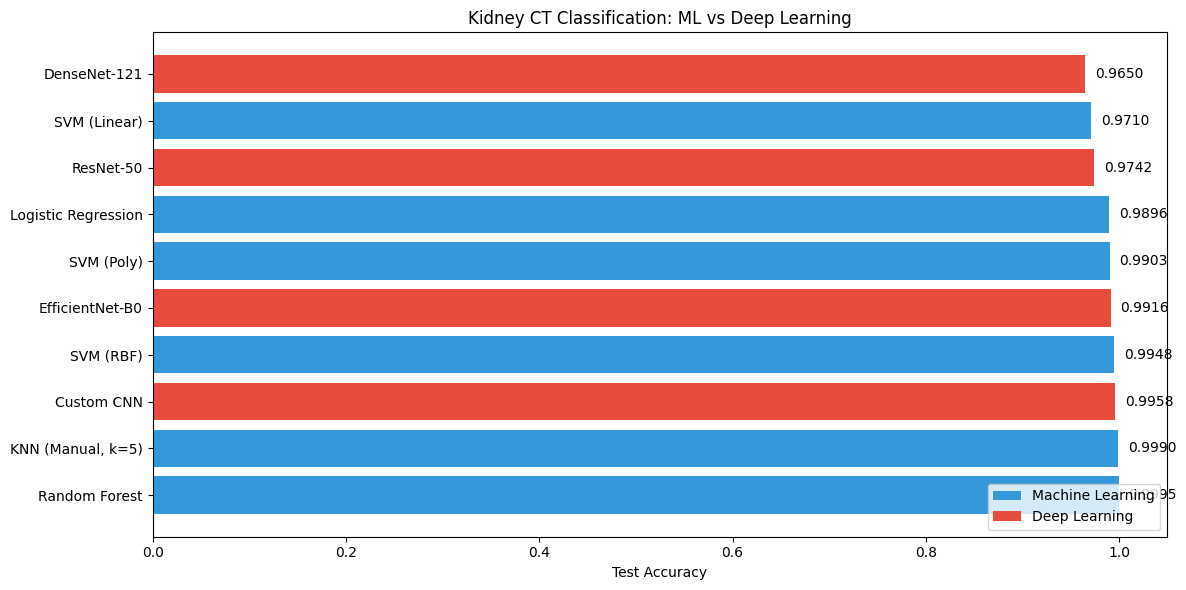

In [125]:
# Final comparison visualization
if dl_results:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Combine all results
    all_models = list(results.keys()) + list(dl_results.keys())
    all_accs = [results[n]['test_acc'] for n in results.keys()] + [dl_results[n]['test_acc'] for n in dl_results.keys()]
    colors = ['#3498db']*len(results) + ['#e74c3c']*len(dl_results)

    # Sort by accuracy
    sorted_data = sorted(zip(all_models, all_accs, colors), key=lambda x: x[1], reverse=True)
    all_models, all_accs, colors = zip(*sorted_data)

    bars = ax.barh(all_models, all_accs, color=colors)
    ax.set_xlabel('Test Accuracy')
    ax.set_title('Kidney CT Classification: ML vs Deep Learning')
    ax.set_xlim(0, 1.05)

    # Add value labels
    for bar, acc in zip(bars, all_accs):
        ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.4f}', 
                va='center', fontsize=10)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='Machine Learning'),
                       Patch(facecolor='#e74c3c', label='Deep Learning')]
    ax.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'ml_vs_dl_comparison.png'), dpi=150)
    plt.show()
else:
    print("Cannot create comparison chart - no DL results found!")
    print("Run notebooks 02 first, then re-run this cell.")